In [1]:
%matplotlib inline
from matplotlib.colors import LogNorm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import scipy
from scipy import interpolate
import pandas as pd
import itertools

from root_numpy import root2array

Welcome to ROOTaaS 6.06/06


In [48]:
fname_tree     = "./flashmatchcalib_output_merged.root"
fname_spectree = "./flashmatchcalib_output_merged.root"

raw_df1 = pd.DataFrame(root2array(fname_tree,'flashmatchcalib/tree'))
raw_df2 = pd.DataFrame(root2array(fname_spectree,'flashmatchcalib/spectree'))

raw_df = pd.concat([raw_df1, raw_df2], axis=1)


print raw_df.columns
print len(raw_df)

df = raw_df.query('-100 < ((tpc_xmin - t0*0.11) - qll_xmin) and ((tpc_xmin - t0*0.11) - qll_xmin) < 100 and tpcid==0')
#df = raw_df.query('(tpc_xmin - t0*0.11) > 150 and tpcid==0')
#df = raw_df.query('-10 < ((tpc_xmin - t0*0.11) - qll_xmin) and ((tpc_xmin - t0*0.11) - qll_xmin) < 10 and tpcid==0')
df = df.query('not score == inf')
print len(df)

hypo_v = df.hypo_spec.values
flash_v = df.flash_spec.values

t0_v = df.t0.values



Index([u'run', u'subrun', u'event', u'matchid', u'tpcid', u'flashid',
       u'tpc_xmin', u'qll_xmin', u't0', u'score', u'hypo_pe', u'flash_pe',
       u'run', u'subrun', u'event', u'matchid', u'flash_spec', u'hypo_spec'],
      dtype='object')
61362
45513


## Raw Fraction Difference Plot

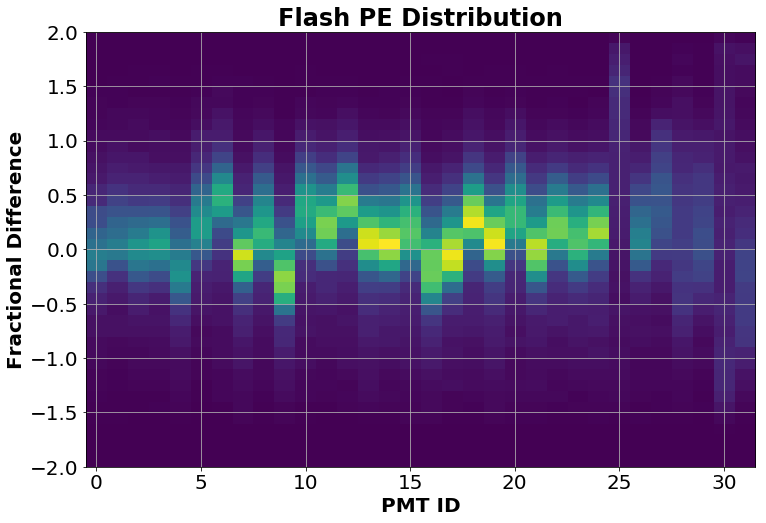

In [49]:
data_x = []
data_y = []
calib_data={}
for pmt in xrange(32):
    calib_data[pmt]=[]
for idx in xrange(len(hypo_v)):
    for pmt in xrange(32):
        hypo = hypo_v[idx][pmt]
        flash = flash_v[idx][pmt]
        if flash < 30 or hypo < 30: continue
        if flash > 300: continue
        data_x.append(pmt)
        asymm = (hypo-flash)/(hypo+flash)*2
        data_y.append(asymm)
        if asymm < 1.0 and asymm > -1.0:
            calib_data[pmt].append(asymm)
data_x = np.array(data_x)
data_y = np.array(data_y)

fig, ax = plt.subplots(figsize=(12, 8),facecolor='w')
plt.hist2d(data_x,data_y,bins=(32,40),range=((-0.5,31.5),(-2,2)))
plt.tick_params(labelsize=20)
plt.grid()
plt.ylabel('Fractional Difference',fontsize=20,fontweight='bold')
plt.xlabel('PMT ID',fontsize=20,fontweight='bold')
#leg=plt.legend(fontsize=20,loc=1)
#leg_frame=leg.get_frame()
#leg_frame.set_facecolor('white')
plt.title('Flash PE Distribution',fontsize=24,fontweight='bold')
plt.show() 

## Calculate and plot correction factors to bring above values around 1

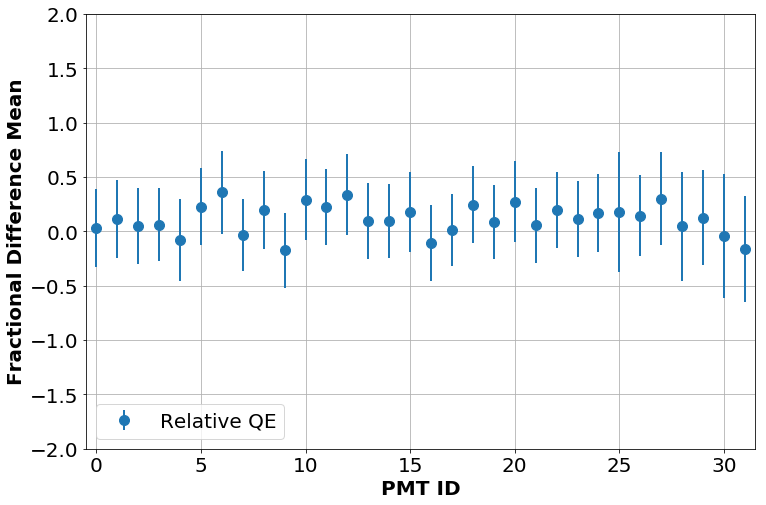

[ 1.03010428  1.12247025  1.05450943  1.06359997  0.92496701  1.2578555
  1.43642184  0.97097869  1.21723329  0.8386987   1.3381655   1.25068641
  1.40546547  1.09691199  1.09919327  1.19272144  0.89838785  1.01445028
  1.27903301  1.09130308  1.31567592  1.0577623   1.21757927  1.11874269
  1.18458922  1.20015619  1.15704964  1.35078128  1.04760561  1.13483661
  0.95729313  0.84910329]
QE correction mean: 0.901316078157
QE correction spread: 0.125796290654


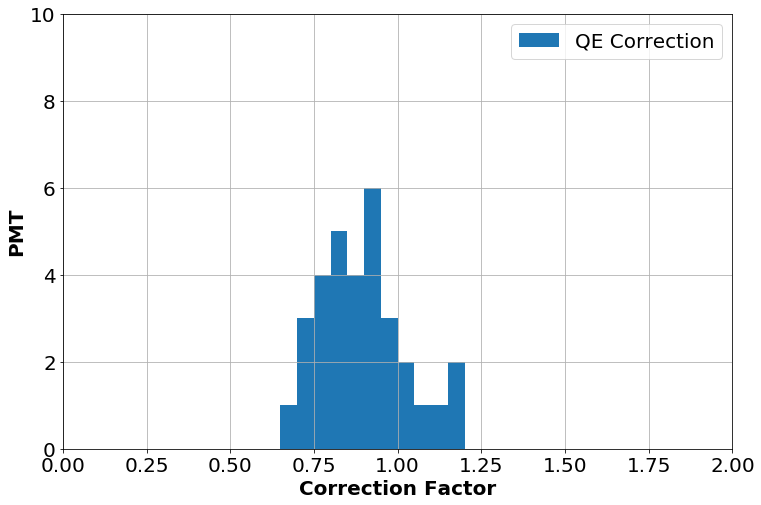

In [50]:
calib_factor={}
data_x=[]
data_y=[]
err_y=[]
for pmt in xrange(32):
    calib_data[pmt] = np.array(calib_data[pmt])
    xfactor = calib_data[pmt].mean()
    calib_factor[pmt] = (2.-xfactor)/(2.+xfactor)
    #print 'pmt',pmt,'calib factor',calib_factor[pmt]
    data_x.append(pmt)
    data_y.append(calib_data[pmt].mean())
    err_y.append(calib_data[pmt].std())
    
fig = plt.figure(figsize=(12,8),facecolor='w')
ax = fig.add_subplot(1,1,1)
ax.errorbar(data_x,data_y,yerr=err_y, fmt='o',label='Relative QE',markersize=10,linewidth=2)
#ax.plot(xdata,ydata, marker='+', linestyle='none', label=r'data')
#ax.plot(xdata,yfit, color='green', label=r'unbounded')
#ax.plot(xx,yfit_lim1, color='red', label=r'bound amplitude')
#ax.plot(xx,yfit_lim2, color='orange', label=r'bound mean')
ax.legend(numpoints=1, loc='upper left')
plt.ylim(-2,2)
plt.tick_params(labelsize=20)
plt.grid()
plt.ylabel('Fractional Difference Mean',fontsize=20,fontweight='bold')
plt.xlabel('PMT ID',fontsize=20,fontweight='bold')
leg=plt.legend(fontsize=20,loc=3)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.title('',fontsize=24,fontweight='bold')
plt.xlim(-0.5,31.5)
plt.show()


data = np.array(calib_factor.values())
print 1/data
print 'QE correction mean:',data.mean()
print 'QE correction spread:',data.std()
fig = plt.figure(figsize=(12,8),facecolor='w')
ax = fig.add_subplot(1,1,1)
plt.hist(calib_factor.values(),bins=40,range=(0,2),label='QE Correction')
#ax.plot(xdata,ydata, marker='+', linestyle='none', label=r'data')
#ax.plot(xdata,yfit, color='green', label=r'unbounded')
#ax.plot(xx,yfit_lim1, color='red', label=r'bound amplitude')
#ax.plot(xx,yfit_lim2, color='orange', label=r'bound mean')
ax.legend(numpoints=1, loc='upper left')
plt.tick_params(labelsize=20)
plt.grid()
plt.ylim(0,10)
plt.ylabel('PMT',fontsize=20,fontweight='bold')
plt.xlabel('Correction Factor',fontsize=20,fontweight='bold')
leg=plt.legend(fontsize=20,loc=0)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.title('',fontsize=24,fontweight='bold')
plt.xlim(0,2)
plt.show()

## Corrected Fractional Difference Distribution

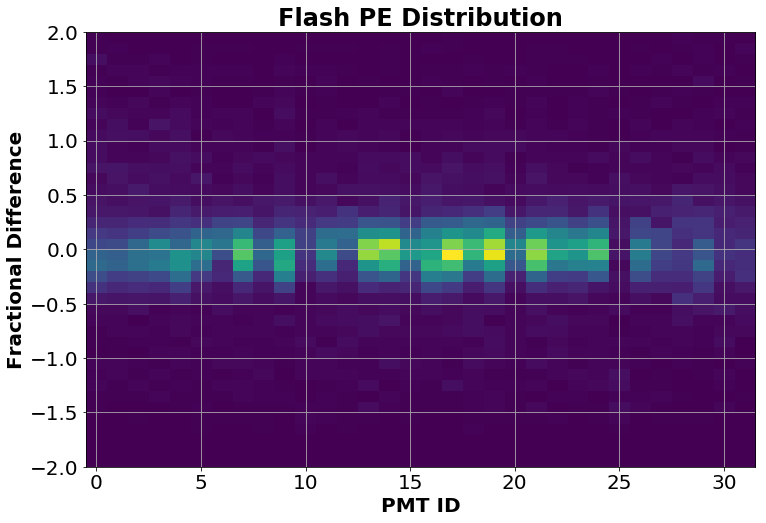

In [44]:
data_x = []
data_y = []
for idx in xrange(len(hypo_v)):
    for pmt in xrange(32):
        hypo = float(hypo_v[idx][pmt])
        flash = float(flash_v[idx][pmt])
        if flash < 30 or hypo < 30: continue
        if flash > 300: continue
        hypo *= calib_factor[pmt] 
        data_x.append(pmt)
        data_y.append((hypo-flash)/(hypo+flash)*2.)
        
data_x = np.array(data_x)
data_y = np.array(data_y)

fig, ax = plt.subplots(figsize=(12, 8),facecolor='w')
plt.hist2d(data_x,data_y,bins=(32,40),range=((-0.5,31.5),(-2,2)))
plt.tick_params(labelsize=20)
plt.grid()
plt.ylabel('Fractional Difference',fontsize=20,fontweight='bold')
plt.xlabel('PMT ID',fontsize=20,fontweight='bold')
leg=plt.legend(fontsize=20,loc=1)
#leg_frame=leg.get_frame()
#leg_frame.set_facecolor('white')
plt.title('Flash PE Distribution',fontsize=24,fontweight='bold')
plt.show() 